# Energy Consumption Prediction

In this project, a deep learning model will be developed to predict the amount of energy consumed by a building with solar panel. The deep learning model will use tensorflow/keras framework. A baseline model (*Sequential Model*) and a proposed model (*Functional Model*) would be developed.

<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>Month</td>
<td>The month of the year when the data was recorded.</td>
</tr>
<tr>
<td>Hour</td>
<td>The hour of the day when the data was recorded.</td>
</tr>
<tr>
<td>DayOfWeek</td>
<td>The day of the week when the data was recorded.</td>
</tr>
<tr>
<td>Holiday</td>
<td>Indicates whether the day was a holiday (Yes/No).</td>
</tr>
<tr>
<td>Temperature</td>
<td>The average daily temperature in Celsius.</td>
</tr>
<tr>
<td>Humidity</td>
<td>The average daily humidity level (%).</td>
</tr>
<tr>
<td>SquareFootage</td>
<td>The area of the building being monitored in m<sup>2</sup>.</td>
</tr>
<tr>
<td>Occupancy</td>
<td>The total number of people occupying the building.</td>
</tr>
<tr>
<td>HVACUsage</td>
<td>Indicates whether the HVAC system was in use (On/Off).</td>
</tr>
<tr>
<td>LightingUsage</td>
<td>Indicates whether the lighting system was in use (On/Off).</td>
</tr>
<tr>
<td>RenewableEnergy</td>
<td>The amount of renewable energy generated at the time of data collection. (Kwh)</td>
</tr>
<tr>
<td>EnergyConsumption (the goal)</td>
<td>The amount of energy consumed at the time of data collection. (Kwh)</td>
</tr>
</table>

## Importing the Needed Libraries

In [1]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, Any

# Data prepreocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Concatenate

# Model Evaluation Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning Libraries
import optuna

## Import the Data

In [2]:
data = pd.read_parquet("dataset_1A.parquet")
data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


## EDA

### Check the Missing Values and Duplicates

#### The Number of Missing Values

In [3]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


#### Check for Duplicates

In [4]:
print(data.duplicated().sum())

0


### Check the Data Types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


The data is roughly clean so far with some correct data types and no missing values. However the "EnergyConsumption" column has a wrong data type where it should be float64. Therefore, we will change that data type.

In [6]:
# Changing the data type of "EnergyConsumption"
data["EnergyConsumption"] = data["EnergyConsumption"].astype("float64")

In [7]:
# Recheck the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


### Check if there are more missing data after conversion

In [8]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.00
Hour,0,0.00
DayOfWeek,0,0.00
Holiday,0,0.00
Temperature,0,0.00
Humidity,0,0.00
SquareFootage,0,0.00
Occupancy,0,0.00
HVACUsage,0,0.00
LightingUsage,0,0.00


In [9]:
# Since there are some missing values in the dataset, we need to handle them.
data = data.dropna(axis=0)

# Recheck the data
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


### Check the Range of the "Hours" Column

Let's check the "Hours" to get the range of the time is it a 12 hour format or a 24 hour format

In [10]:
min(data["Hour"]), max(data["Hour"]) 

(0, 23)

Looks like the data is in a 24 hour format so lets change it to a time format of HH:MM

### Plotting Data Distribution

#### Functions for plotting the distribution

In [11]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [12]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [13]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories
        
        #Create the bar plot
        axes[i].bar(counts.index, counts)
        
        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

#### Splitting Data to Categorical and Numeric

In [14]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

#### Numerical Data Plot

In [15]:
numeric_data.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
0,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358
1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177
2,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098
3,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179
4,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

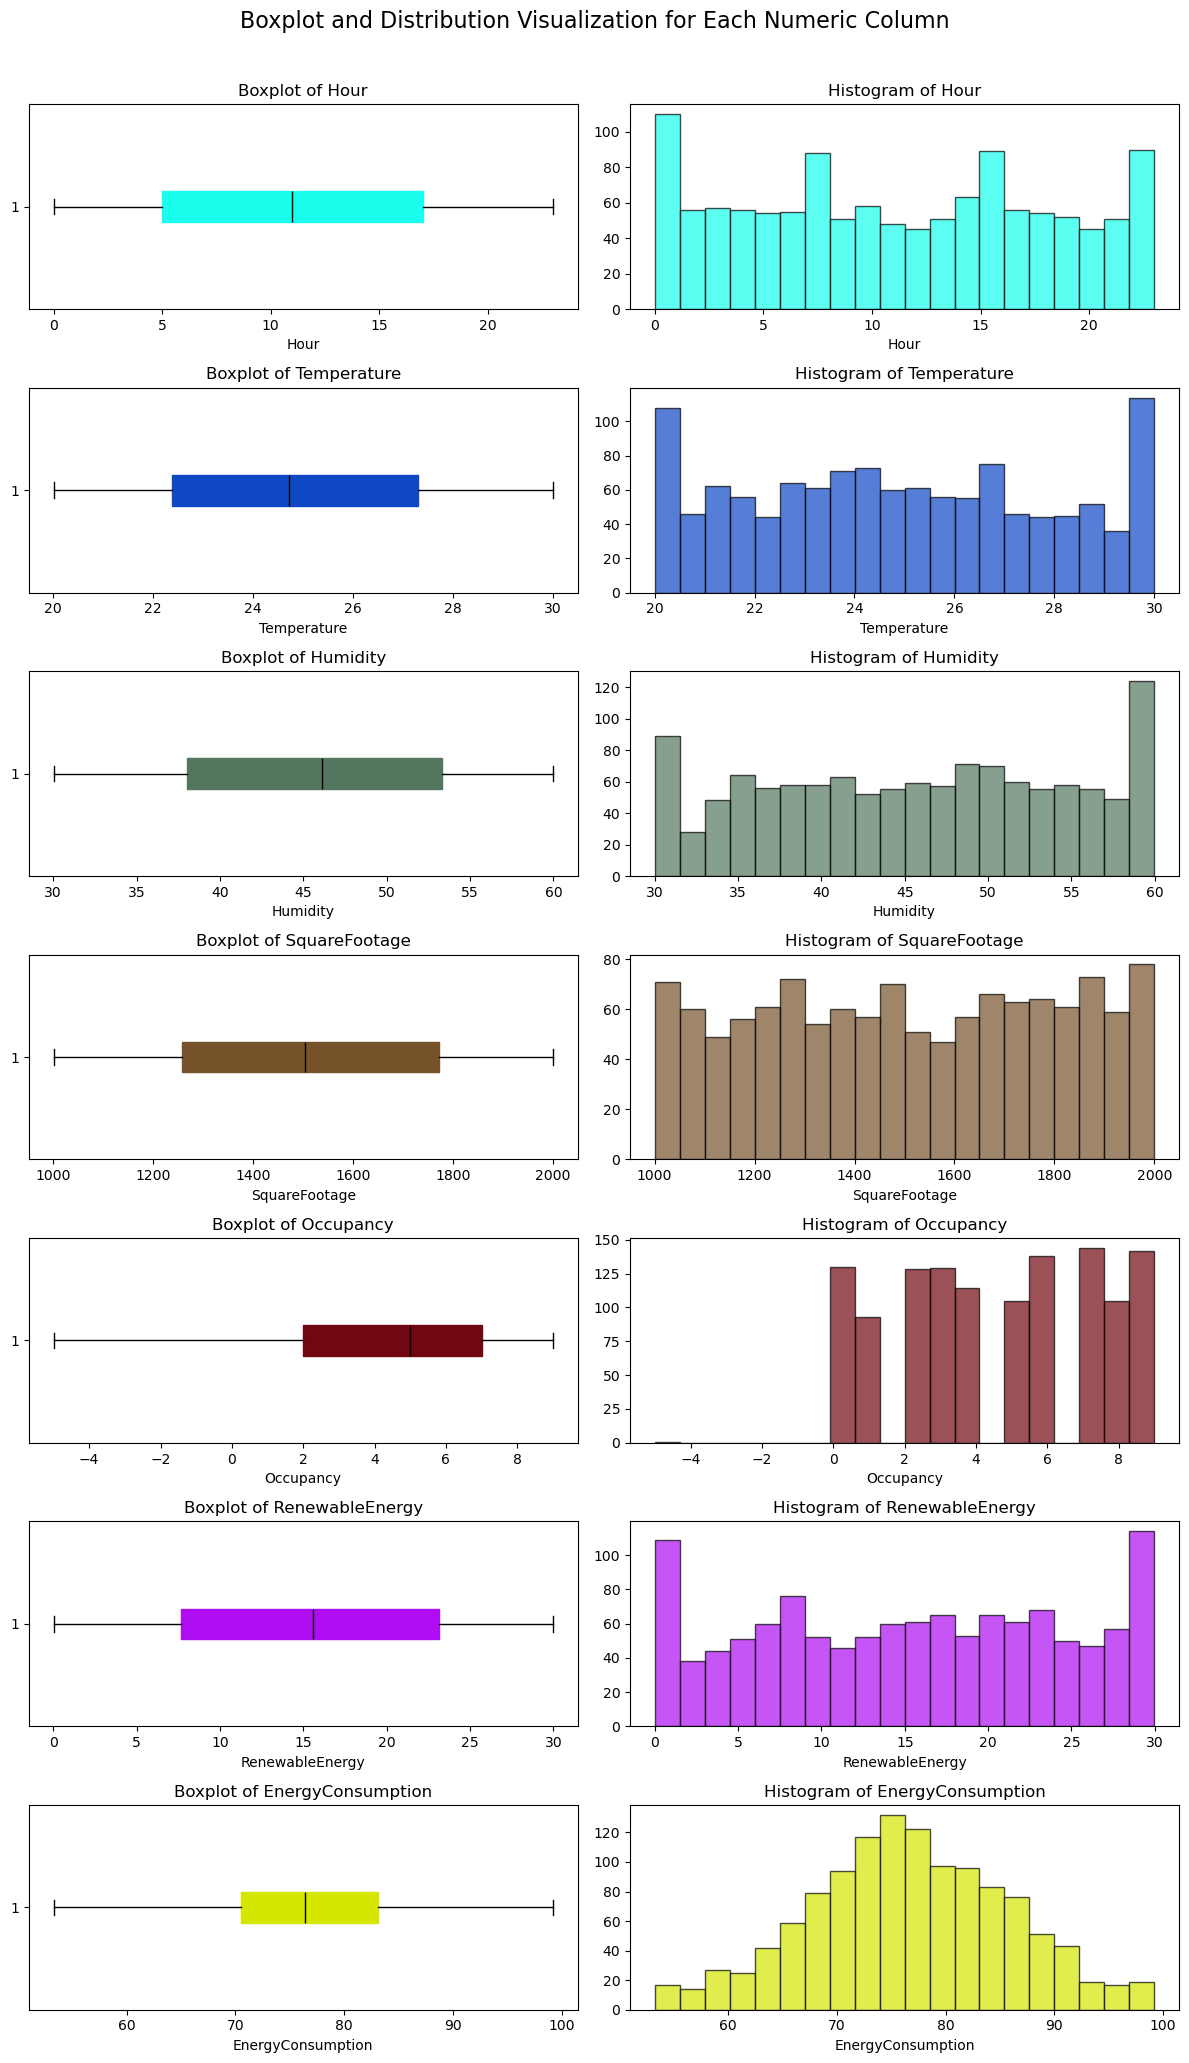

In [16]:
numeric_dist_plot(numeric_data)

#### Categorical Data Plot

In [17]:
categorical_data.head()

,Month,DayOfWeek,Holiday,HVACUsage,LightingUsage
0,8,Sunday,Yes,On,Off
1,1,Wednesday,No,On,Off
2,1,Sunday,Yes,Off,On
3,7,Wednesday,Yes,Off,On
4,10,Saturday,No,Off,Off


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

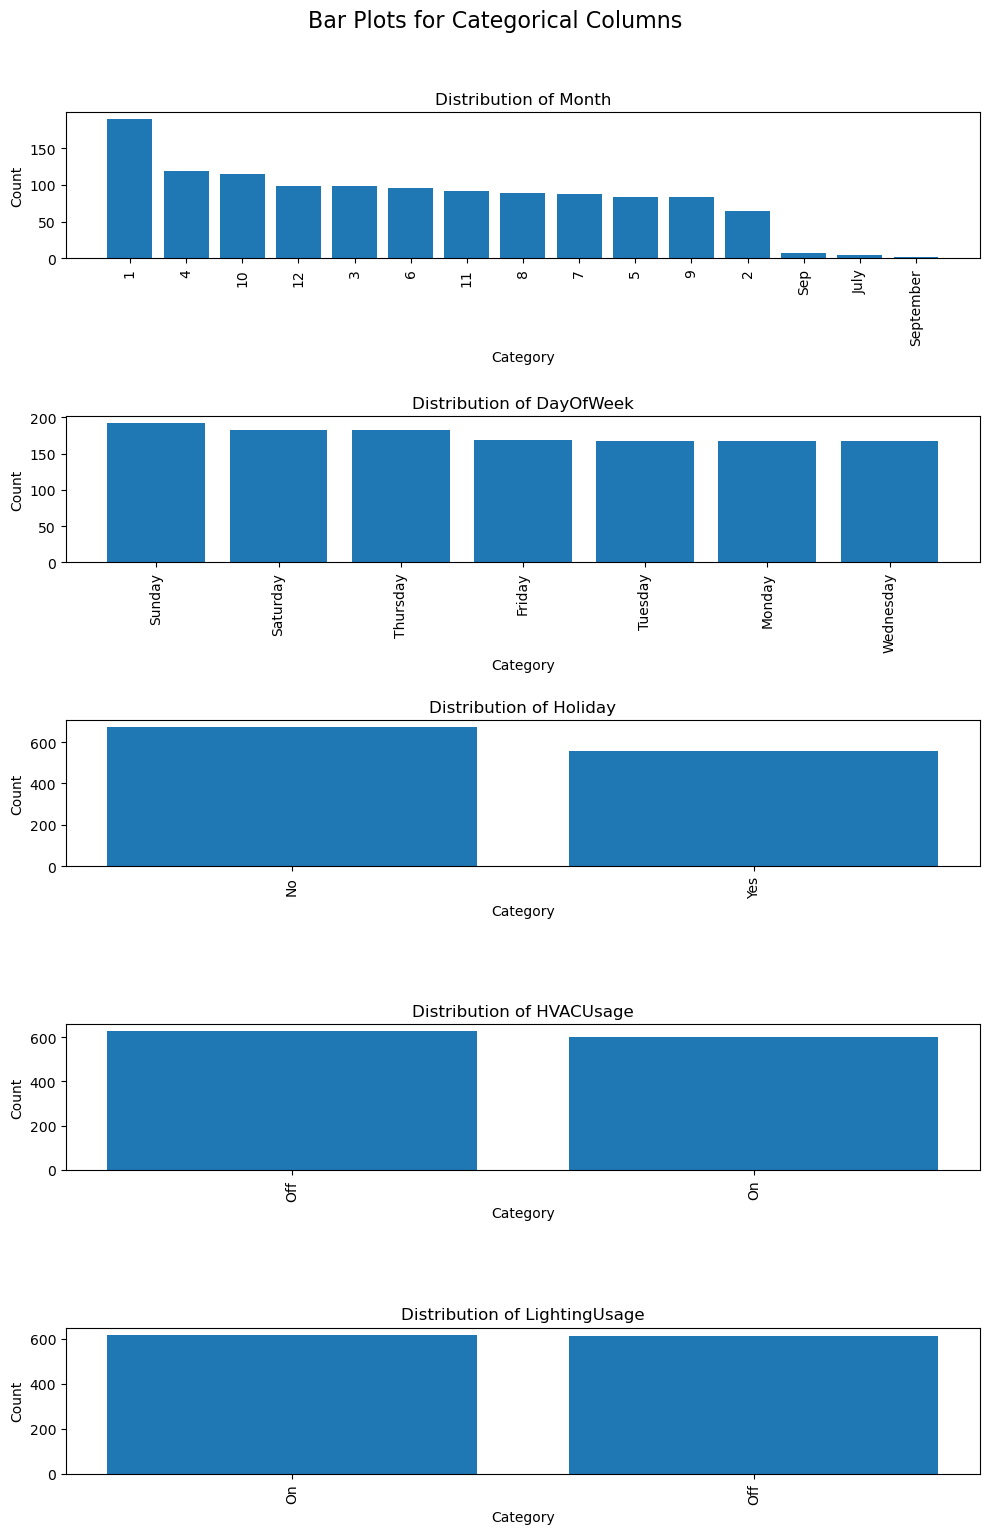

In [18]:
categoric_dist_plot(categorical_data)

### Key Insights
#### Problems With the Data
1. **Inconcistent Data Values**:
   - The months in the data is inconsistent. There are 3 types of month in the data (e.g. Numerical, partial month name, and full month name)
2. **Wierd Data Range**:
   - There seems to be a negative number of Occupancy as seen in the graph, and that is a outlier since there is nothing such as a negative number of people.
3. **Skewness**:
   - There are some skewness in the month data where there are mostly data from january. Which may impact model's performance/
   - The rest of the data are mostly uniform except for EnergyConsumption where it has a normal distribution. 

#### Small Fixes
4. **Data Types**:
- Changing the data type of "EnergyConsumption" from `object` to `float64`
- Removed Missing values from the data

#### Next Steps
- Further Clean the data due to inconsistencies

## Data Cleaning

- Standardizing the "month" data
- Cleaning the negative number of occupancy

### Standardizing the "month" data

#### String to month number

In [19]:
def str_to_month(String: str) -> str:
    """This function converts a string to a month type. The string can be in the format of "Jan", "Feb", etc. or "January", "February", etc.
    It will return the month number as a string. If the string is not in the correct format, it will return NaT.

    Args:
        String (str): The string to be converted to a month number.

    Raises:
        TypeError: 'The following value is not a string: {String}'
        This is due to the fact that the input is not a string.

    Returns:
        str: The month number as a string or NaT if the conversion failed.
    """
    # Check
    ## Check if the text is a string
    if not isinstance(String, str):
        raise TypeError(f"The following value is not a string: {String}")
    
    try:
        # If the string is already in a number format, convert it to a month number
        if String.isdecimal():
            # Check if the string is a number between 1 and 12 (january to december)
            num = int(String)
            if 1 <= num <= 12:
                dt = pd.to_datetime(num, format = '%m')
                return f"{dt.month:01d}"
            else:
                return pd.NaT
            
        # Try full month name
        try:
            dt = pd.to_datetime(String, format = '%B')  # e.g., 'January'
        except ValueError:
            dt = pd.to_datetime(String, format = '%b')  # e.g., 'Jan'

        return f"{dt.month:01d}"
    
    except Exception:
        #Return NA if the string conversion failed
        return pd.NaT

#### Apply the month to number function to the dataset

In [20]:
data["Month"] = data["Month"].apply(str_to_month)

### Cleaning the data with negative occupancy

#### Check if the data is present

In [21]:
data[data["Occupancy"] < 0]

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
975,10,4,Thursday,No,21.636782,51.998664,1442.174322,-5,On,Off,26.078521,84.024705


There is an occupancy with -5 person which is impossible since there is no such thing as negative number of persons. So removing the data would be beneficial for a cleaner data fror the deep learning model.

In [22]:
data = data.drop(data[data["Occupancy"] < 0].index).reset_index(drop=True)

### Rechecking the distribution of the data

In [23]:
categorical_data = data.select_dtypes(exclude=[np.number])
numeric_data = data.select_dtypes(include=[np.number])

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

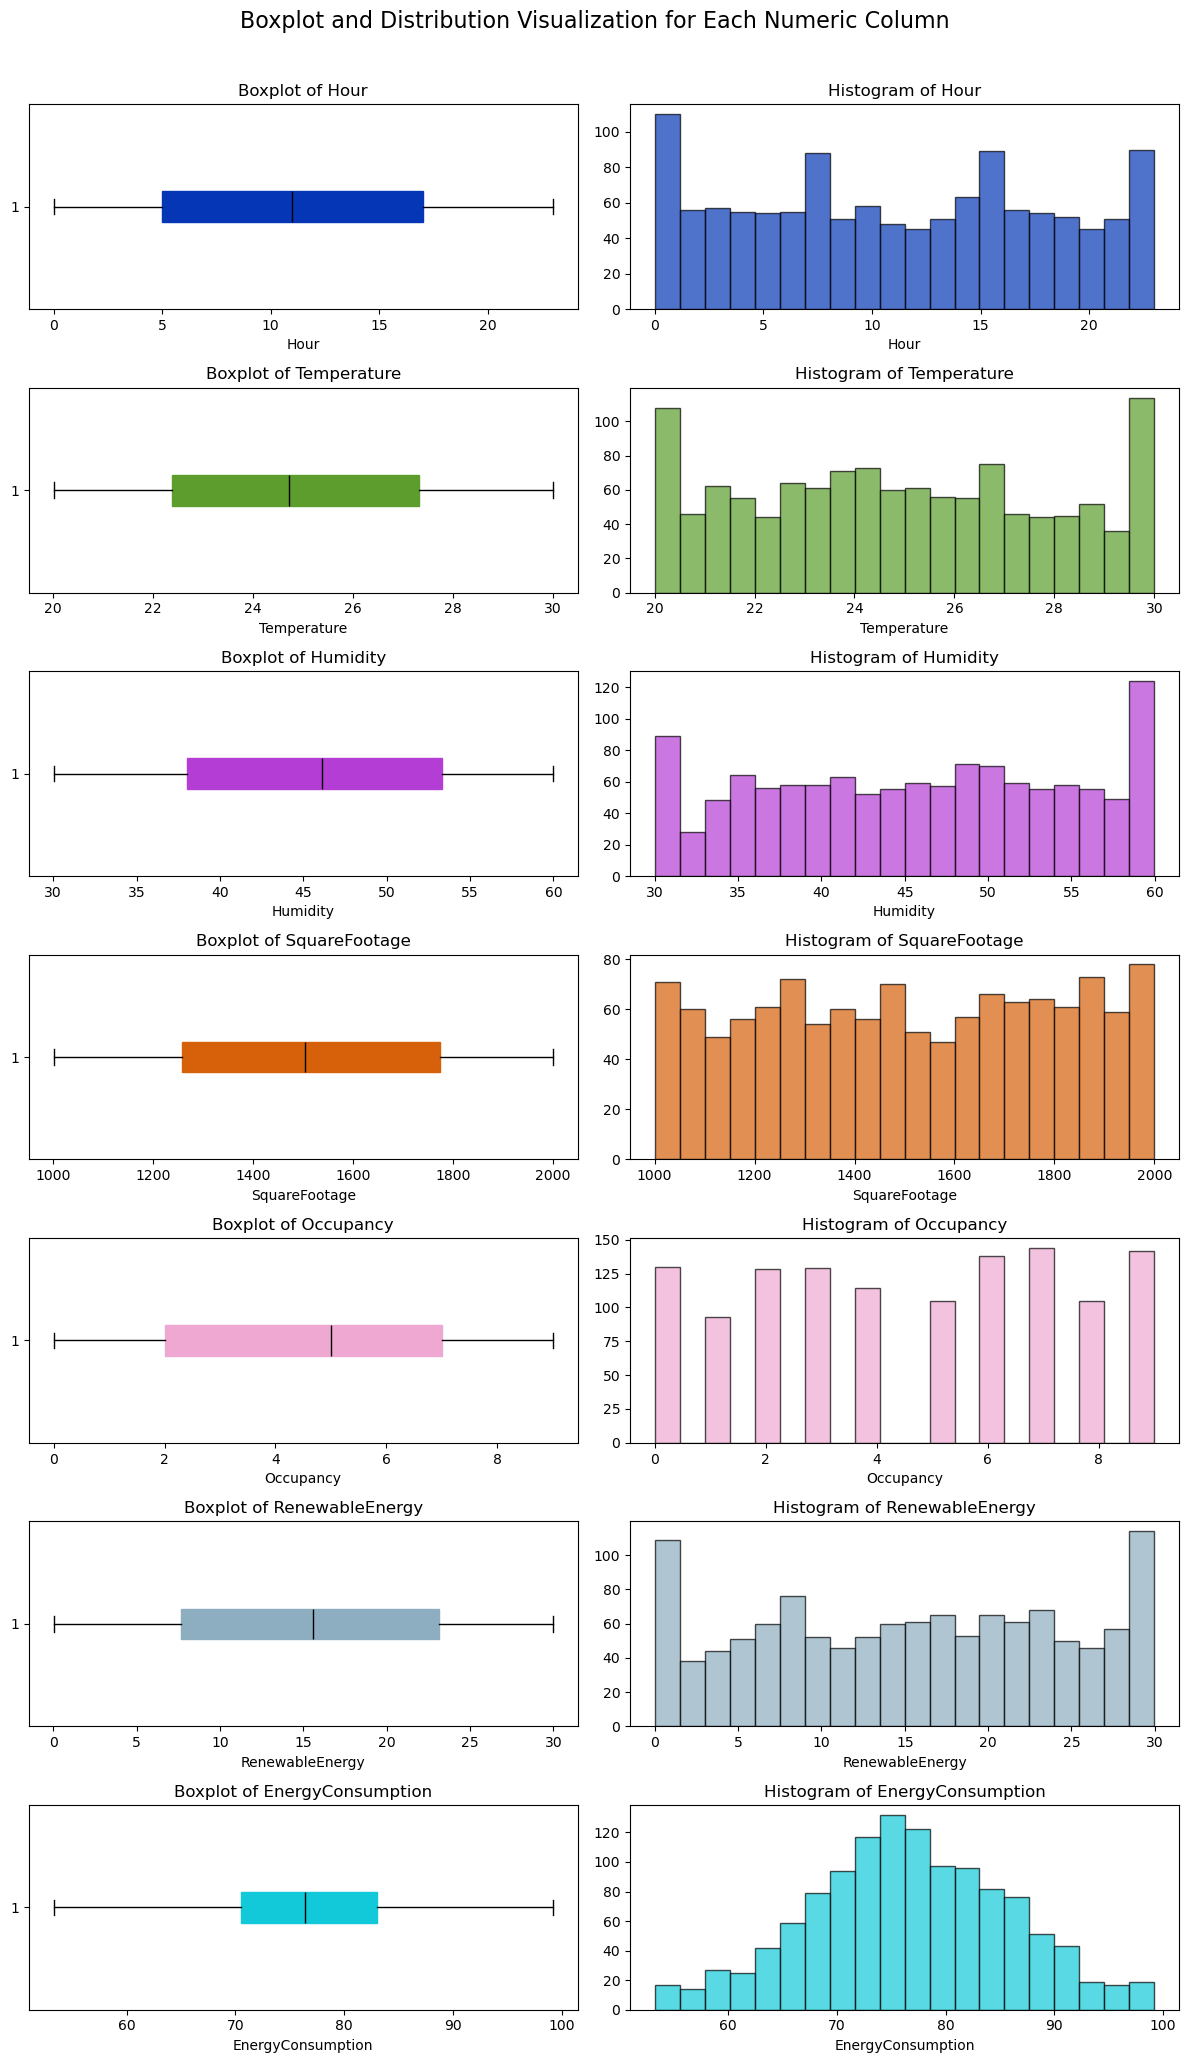

In [24]:
numeric_dist_plot(numeric_data)

<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\TF_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

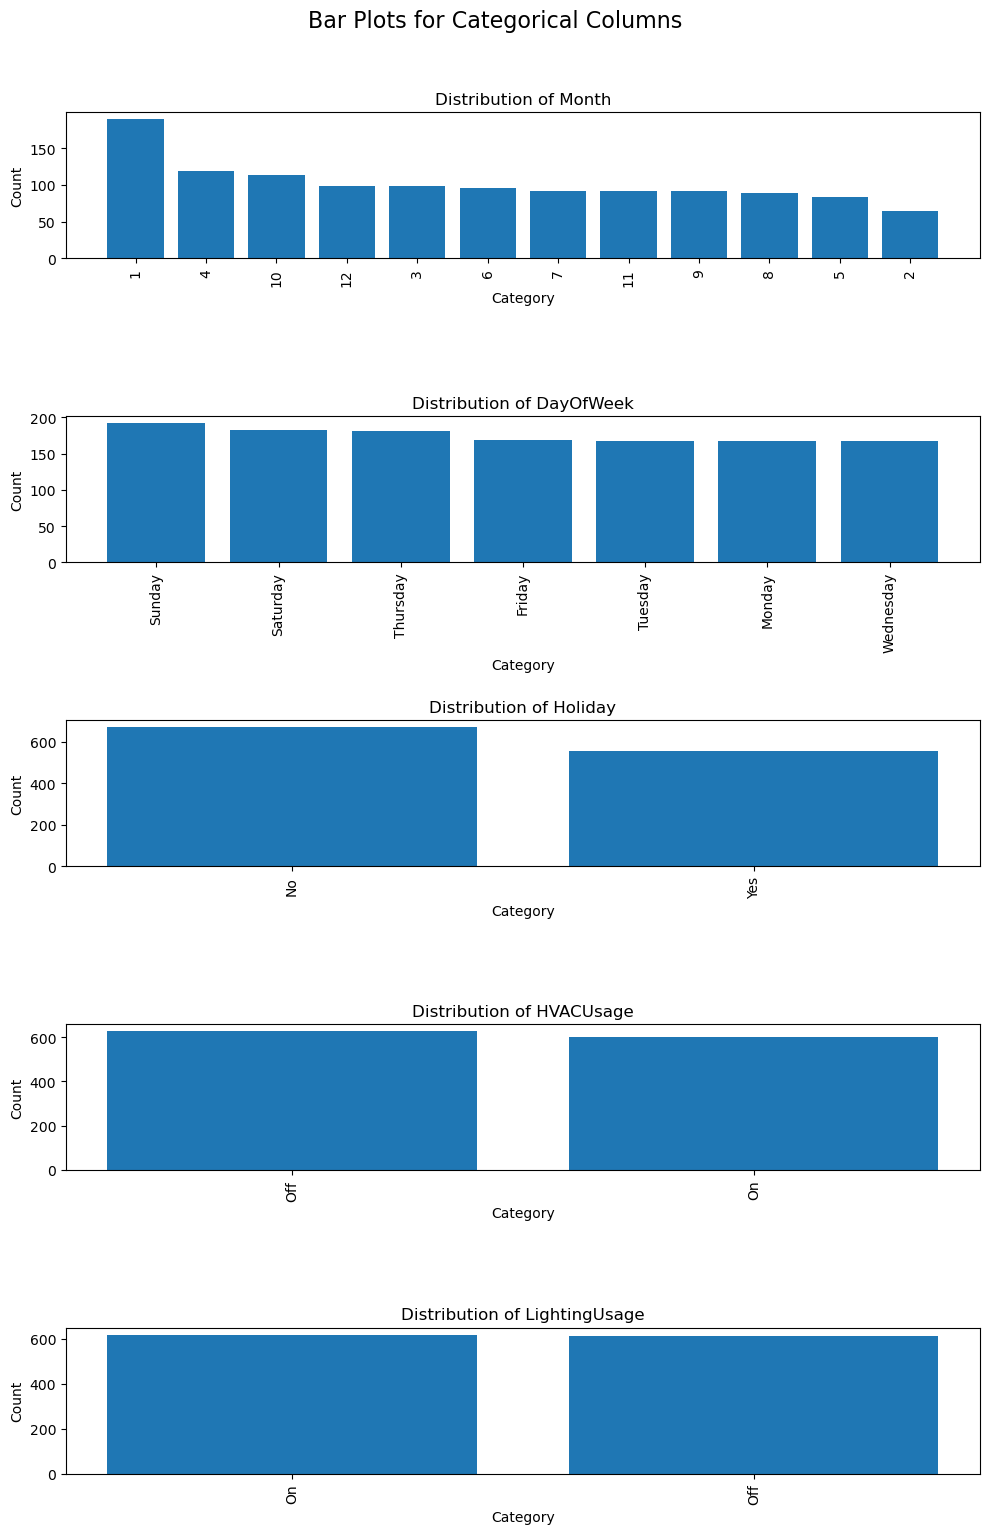

In [25]:
categoric_dist_plot(categorical_data)

### Summary Of Data Cleaning
#### Key Insights:
1. **Inconsistent Data Values**:
    - The "Month" column had inconsistent formats (e.g., numeric, full names, abbreviations), which were standardized.
2. **Outliers**:
    - Negative values in the "Occupancy" column were identified and removed.

3. **Skewness**:
    - The "EnergyConsumption" column has a normal distribution, while other numerical columns show varying degrees of skewness.

4. **Categorical Data**:
    - Some categorical columns, such as "Holiday" and "HVACUsage," have imbalanced distributions, which may impact model performance.

5. **Data Cleaning**:
    - After cleaning, the dataset is now consistent and ready for preprocessing and modeling.

#### Next Steps:
- Scale numerical data to ensure uniformity.
- Encode categorical data for compatibility with machine learning models.
- Split the data into training, validation, and testing sets for model development.

**At this point**:
- The dataset is now clean and ready for further preprocessing or modeling.
- The handling of missing values and standardization of date formats ensures consistency.

## Data Propressing

### Spitting data to train, test, and validation

#### Split data to the predictor and outcome

In [26]:
x_data = data.drop(columns=["EnergyConsumption"])
y_data = data["EnergyConsumption"]

In [27]:
# Check the columns
x_data.columns

Index(['Month', 'Hour', 'DayOfWeek', 'Holiday', 'Temperature', 'Humidity',
       'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage',
       'RenewableEnergy'],
      dtype='object')

In [28]:
y_data.head()

0    82.057358
1    83.889177
2    66.202098
3    66.439179
4    76.902272
Name: EnergyConsumption, dtype: float64

####  Split to train and test

In [29]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((982, 11), (246, 11), (982,), (246,))

#### Split to train and validation

In [30]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((785, 11), (197, 11), (785,), (197,))

So after splitting the data we will obtain the following:
<table>
<tr>
<th>Data</th>
<th>Size</th>
</tr>
<tr>
<td>Train</td>
<td>788</td>
</tr>
<tr>
<td>Validation</td>
<td>197</td>
</tr>
<tr>
<td>Test</td>
<td>247</td>
</tr>

### Scaling the Data

#### Scaling the numerical data

All the numerical features will use min max scaling since there are no outliers, and the data is almost uniformly distributed.

In [31]:
hoursScaler = MinMaxScaler()
tempScaler = MinMaxScaler()
humidScaler = MinMaxScaler()
squareScaler = MinMaxScaler()
occupancyScaler = MinMaxScaler()
renewableScaler = MinMaxScaler()
energyScaler = MinMaxScaler()

##### Apply to train data

In [32]:
# The x features
train_x["Hour"] = hoursScaler.fit_transform(train_x[["Hour"]])
train_x["Temperature"] = tempScaler.fit_transform(train_x[["Temperature"]])
train_x["Humidity"] = humidScaler.fit_transform(train_x[["Humidity"]])
train_x["SquareFootage"] = squareScaler.fit_transform(train_x[["SquareFootage"]])
train_x["Occupancy"] = occupancyScaler.fit_transform(train_x[["Occupancy"]])
train_x["RenewableEnergy"] = renewableScaler.fit_transform(train_x[["RenewableEnergy"]])

# The y value
train_y = energyScaler.fit_transform(train_y.values.reshape(-1, 1))

##### Apply to validation data

In [33]:
# The x features
val_x["Hour"] = hoursScaler.transform(val_x[["Hour"]])
val_x["Temperature"] = tempScaler.transform(val_x[["Temperature"]])
val_x["Humidity"] = humidScaler.transform(val_x[["Humidity"]])
val_x["SquareFootage"] = squareScaler.transform(val_x[["SquareFootage"]])
val_x["Occupancy"] = occupancyScaler.transform(val_x[["Occupancy"]])
val_x["RenewableEnergy"] = renewableScaler.transform(val_x[["RenewableEnergy"]])

# The y value
val_y = energyScaler.transform(val_y.values.reshape(-1, 1))

##### Apply to test data

In [34]:
# The x features
test_x["Hour"] = hoursScaler.transform(test_x[["Hour"]])
test_x["Temperature"] = tempScaler.transform(test_x[["Temperature"]])
test_x["Humidity"] = humidScaler.transform(test_x[["Humidity"]])
test_x["SquareFootage"] = squareScaler.transform(test_x[["SquareFootage"]])
test_x["Occupancy"] = occupancyScaler.transform(test_x[["Occupancy"]])
test_x["RenewableEnergy"] = renewableScaler.transform(test_x[["RenewableEnergy"]])

# The y value
test_y = energyScaler.transform(test_y.values.reshape(-1, 1))

### Encoding the Categorical Data

Binary Columns: `LightingUsage`, `HVACUsage`, `Holiday`

Nominal Columns: `DayOfWeek`

Ordinal Columns: `Month`

In [35]:
# The Values in the columns
for col in categorical_data.columns:
    print(f"{col}: {categorical_data[col].unique()} \n")

Month: ['8' '1' '7' '10' '4' '2' '5' '6' '11' '9' '12' '3'] 

DayOfWeek: ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday'] 

Holiday: ['Yes' 'No'] 

HVACUsage: ['On' 'Off'] 

LightingUsage: ['Off' 'On'] 



In [36]:
binary_cols_1 = ["Holiday"]
binary_cols_2 = ["HVACUsage", "LightingUsage"] # Use Label enconder (On or Off)
nominal_cols = ["DayOfWeek"] # Use OneHotEncoder
ordinal_cols = ["Month"] # Use OrdinalEncoder

#### Encoder Setup

In [37]:
bin_enc_1 = LabelEncoder()
bin_enc_2 = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
ordinal_enc = OrdinalEncoder(categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]], handle_unknown="use_encoded_value", unknown_value=-1).set_output(transform="pandas")

#### Transforming the Train Data

##### Binary Data

In [38]:
bin_data = pd.concat([train_x[binary_cols_1].apply(bin_enc_1.fit_transform), train_x[binary_cols_2].apply(bin_enc_2.fit_transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
431,0,1,0
329,0,0,1
1051,1,1,1
22,0,1,1
1222,0,0,0


##### Nominal Data

In [39]:
nominal_data = ohe.fit_transform(train_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
431,0.0,0.0,0.0,0.0,0.0,0.0,1.0
329,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1222,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### Ordinal Data

In [40]:
ordinal_data = ordinal_enc.fit_transform(train_x[ordinal_cols])
ordinal_data.head()

,Month
431,4.0
329,7.0
1051,9.0
22,10.0
1222,0.0


##### Reunite the dataset

In [41]:
train_x = pd.concat([train_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
train_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
431,0.869565,0.635707,1.000000,1.000000,0.000000,0.004840,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
329,0.173913,0.987916,1.000000,0.154359,0.666667,0.881296,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1051,0.000000,0.247066,0.385912,0.330254,0.222222,0.432479,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
22,0.000000,0.820101,0.694746,0.324268,0.333333,0.559751,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
1222,0.608696,0.682566,0.763241,0.262256,0.333333,0.803954,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Transforming the Validation Data

##### Binary Data

In [42]:
bin_data = pd.concat([val_x[binary_cols_1].apply(bin_enc_1.transform), val_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
186,1,0,0
928,0,1,1
863,1,0,0
167,1,0,0
136,1,1,1


##### Nominal Data

In [43]:
nominal_data = ohe.transform(val_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
186,0.0,0.0,1.0,0.0,0.0,0.0,0.0
928,0.0,0.0,0.0,0.0,1.0,0.0,0.0
863,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,1.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Ordinal Data

In [44]:
ordinal_data = ordinal_enc.transform(val_x[ordinal_cols])
ordinal_data.head()

,Month
186,3.0
928,0.0
863,3.0
167,7.0
136,11.0


##### Reunite the dataset

In [45]:
val_x = pd.concat([val_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
val_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
186,0.173913,0.677827,0.922215,0.000000,0.333333,0.423396,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
928,0.173913,0.203936,0.110449,0.734958,0.000000,0.493151,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
863,0.869565,0.877667,0.509860,0.546393,0.222222,0.266117,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
167,0.782609,0.570794,0.228420,0.899237,0.444444,0.306755,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
136,0.565217,0.593852,1.000000,0.792945,0.444444,0.288517,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0


#### Transforming the Test Data

##### Binary Data

In [46]:
bin_data = pd.concat([test_x[binary_cols_1].apply(bin_enc_1.transform), test_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
710,0,0,1
486,1,0,0
244,1,0,0
551,1,0,0
1162,1,1,0


##### Nominal Data

In [47]:
nominal_data = ohe.transform(test_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
710,0.0,1.0,0.0,0.0,0.0,0.0,0.0
486,0.0,0.0,0.0,0.0,0.0,1.0,0.0
244,0.0,0.0,0.0,0.0,1.0,0.0,0.0
551,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1162,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Ordinal Data

In [48]:
ordinal_data = ordinal_enc.transform(test_x[ordinal_cols])
ordinal_data.head()

,Month
710,0.0
486,3.0
244,2.0
551,4.0
1162,9.0


##### Reunite the dataset

In [49]:
test_x = pd.concat([test_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
test_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
710,0.913043,0.072880,0.617320,0.836474,0.444444,0.310054,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
486,0.043478,0.583121,0.564254,0.896841,0.666667,0.546465,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
244,0.565217,0.509140,0.006289,0.815548,0.333333,0.949764,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
551,0.217391,0.479635,0.635156,0.559464,0.888889,0.770393,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
1162,0.565217,0.567467,0.223269,0.082053,0.111111,0.000000,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0


In [50]:
test_x.shape

(246, 17)

## Model making

### Baseline Model

We will develop a Sequential Model And Functional Model

Requirements:
1. Relu Activation
2. The minimum Number of neurons is 2x the input data dimension

#### Sequential_model

##### Train the model

In [51]:
seq_model = Sequential()
seq_model.add(Dense(64, input_dim=train_x.shape[1], activation='relu'))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dense(1, activation='relu')) #one numeric output column
seq_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
seq_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 1s 14ms/step - loss: 0.2139 - mse: 0.2139 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 3/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 8/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0274 - mse: 0.

In [52]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


##### Test the model

In [53]:
seq_pred = seq_model.predict(test_x)
print(f"R2 Score: \t{r2_score(test_y, seq_pred)}")
print(f"MSE: \t \t{mean_squared_error(test_y, seq_pred)}")
print(f"MAE: \t \t{mean_absolute_error(test_y, seq_pred)}")

8/8 [==============================] - 0s 2ms/step
R2 Score: 	0.23367117941617155
MSE: 	 	0.03170070438362564
MAE: 	 	0.14146019669406212


The model will undergo hyperparameter tuning to further optimize the model. 

#### Functional Model

##### Train the Model

In [54]:
# Input layer
inputs = Input(shape=(train_x.shape[1],))

# Making hidden layers
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)

# Output layer
output = Dense(1, activation='relu')(x)  # one numeric output column

#Compile the model
func_model = Model(inputs = inputs, outputs = output)
func_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
func_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 1s 17ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 8/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0279 - mse: 0.

In [55]:
func_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                1152      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


##### Test the Model

In [56]:
func_pred = func_model.predict(test_x)
print(f"R2 Score: \t{r2_score(test_y, func_pred)}")
print(f"MSE: \t \t{mean_squared_error(test_y, func_pred)}")
print(f"MAE: \t \t{mean_absolute_error(test_y, func_pred)}")

8/8 [==============================] - 0s 2ms/step
R2 Score: 	0.21157629232385677
MSE: 	 	0.03261470300313396
MAE: 	 	0.14366889127570662


#### Compare both model performance

In [57]:
comparison = pd.DataFrame({"Metrics": ["R2 Score", "MSE", "MAE"], 
                          "Sequential Model": [r2_score(test_y, seq_pred), mean_squared_error(test_y, seq_pred), mean_absolute_error(test_y, seq_pred)], 
                          "Functional Model": [r2_score(test_y, func_pred), mean_squared_error(test_y, func_pred), mean_absolute_error(test_y, func_pred)]})
comparison.set_index("Metrics", inplace=True)
comparison

,Sequential Model,Functional Model
Metrics,,
R2 Score,0.233671,0.211576
MSE,0.031701,0.032615
MAE,0.141460,0.143669


There is no difference in results between the sequential and functional model. Since there are no difference in the model architecture however different model making.

### Proposed Model

We will develop a Sequential Model And Functional Model with hyperparameter tuning using optuna.

Requirements:
1. Relu Activation
2. The minimum Number of neurons is 2x the input data dimension

#### Sequential Model

We will use optuna for gridsearch

##### Neural Architecture Search Function

In [ ]:
def seq_objective(trial):
    """This function is used to optimize the hyperparameters of the sequential model using Optuna.
    It takes a trial object as input and returns the R2 score of the model on the validation set.

    Args:
        trial (_Optuna trial object_): Optuna trial object
        
    Returns:
        R2_score: R2 score of the model on the validation set
    """
    # Sequential model
    # Suggest hyperparameters
    ## Input Layer
    num_layers = trial.suggest_int('n_layers', 1, 10)
    model = Sequential()
    model.add(Dense(trial.suggest_int('input_l_n_neuron', 17, 256),
                    activation=trial.suggest_categorical('input_l_activation', ['relu', 'linear', 'elu', 'gelu']),
                    input_dim=train_x.shape[1]
                    ))

    ## Hidden Layer
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f'l{i}_n_neuron', 16, 256)
        activation = trial.suggest_categorical(f'l{i}_activation', ['relu', 'linear', 'elu', 'gelu'])
        model.add(Dense(n_neurons, activation=activation))

    ## dropout layer
    if trial.suggest_categorical('dropout', [True, False]):
        model.add(Dropout(trial.suggest_float('dropout_rate', 0.1, 0.5)))
    
    ## Output Layer
    activation = trial.suggest_categorical(f'output_l_activation', ['relu', 'linear', 'elu', 'gelu'])
    model.add(Dense(1, activation=activation))  # output layer

    ## Choose optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    # Train the model
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=10,
              batch_size= trial.suggest_categorical('batch_size', [32, 64, 128]),
              verbose=0)

    # Evaluate
    model_pred = model.predict(val_x)
    r2_score_val = r2_score(val_y, model_pred)
    return r2_score_val

##### Start the search

In [59]:
seq_study = optuna.create_study(direction="maximize") # Maximize the R2 score
seq_study.optimize(seq_objective, n_trials=10, show_progress_bar=True)

print("Number of finished trials: ", len(seq_study.trials))
print("Best seq_trial:")

seq_trial = seq_study.best_trial

print("\tValue: ", seq_trial.value)
print("\tParams: ")

for key, value in seq_trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2025-04-15 16:48:46,142] A new study created in memory with name: no-name-771be631-21d4-4d9d-955d-507fc95c37ec


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step
[I 2025-04-15 16:48:50,493] Trial 0 finished with value: 0.1733483761077943 and parameters: {'n_layers': 10, 'input_l_n_neuron': 33, 'input_l_activation': 'relu', 'l0_n_neuron': 227, 'l0_activation': 'gelu', 'l1_n_neuron': 227, 'l1_activation': 'gelu', 'l2_n_neuron': 94, 'l2_activation': 'linear', 'l3_n_neuron': 237, 'l3_activation': 'elu', 'l4_n_neuron': 40, 'l4_activation': 'linear', 'l5_n_neuron': 223, 'l5_activation': 'elu', 'l6_n_neuron': 72, 'l6_activation': 'gelu', 'l7_n_neuron': 20, 'l7_activation': 'relu', 'l8_n_neuron': 250, 'l8_activation': 'gelu', 'l9_n_neuron': 74, 'l9_activation': 'elu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.1733483761077943.
7/7 [==============================] - 0s 3ms/step
[I 2025-04-15 16:48:52,269] Trial 1 finished with value: 0.18188720619731635 and parameters: {'n_layers': 6, 'input_l_n_neuron': 23, 'input_l_activation

#### Functional Model

We will use optuna for gridsearch

##### Neural Architechture Search Function

In [ ]:
def func_objective(trial):
    """This function is used to optimize the hyperparameters of the functional model using Optuna.
    It takes a trial object as input and returns the R2 score of the model on the validation set.

    Args:
        trial (_Optuna trial object_): Optuna trial object
        
    Returns:
        R2_score: R2 score of the model on the validation set
    """
    # Fucntional model
    # Suggest hyperparameters
    ## Input Layer
    num_layers = trial.suggest_int('n_layers', 1, 10)
    input = Input(shape=(train_x.shape[1],))

    ## Hidden Layer
    x = Dense(trial.suggest_int(f'input_l_n_neuron', 16, 256), 
              activation = trial.suggest_categorical('input_l_activation', ['relu', 'linear', 'elu', 'gelu']))(input)
    
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f'l{i}_n_neuron', 16, 256)
        activation = trial.suggest_categorical(f'l{i}_activation', ['relu', 'linear', 'elu', 'gelu'])
        x = Dense(n_neurons, activation=activation)(x)

    ## dropout layer
    if trial.suggest_categorical('dropout', [True, False]):
        x = Dropout(trial.suggest_float('dropout_rate', 0.1, 0.5))(x)
    
    ## Output Layer
    activation = trial.suggest_categorical(f'output_l_activation', ['relu', 'linear', 'elu', 'gelu'])
    output = Dense(1, activation = activation)(x)  # output layer

    ## Choose optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model = Model(inputs=input, outputs=output)
    # Compile the model
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    # Train the model
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=10,
              batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
              verbose=0)

    # Evaluate
    model_pred = model.predict(val_x)
    r2_score_val = r2_score(val_y, model_pred)
    return r2_score_val

##### Start the search

In [61]:
func_study = optuna.create_study(direction="maximize") # Maximize the R2 score
func_study.optimize(func_objective, n_trials=10, show_progress_bar=True)

print("Number of finished trials: ", len(func_study.trials))
print("Best trial:")

func_trial = func_study.best_trial

print("\tValue: ", func_trial.value)
print("\tParams: ")

for key, value in func_trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2025-04-15 16:49:18,775] A new study created in memory with name: no-name-b4723e34-69b2-49b8-8caa-f6a7b8cf034a


  0%|          | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 0s 7ms/step
[I 2025-04-15 16:49:25,930] Trial 0 finished with value: -0.1270792303849566 and parameters: {'n_layers': 6, 'input_l_n_neuron': 152, 'input_l_activation': 'relu', 'l0_n_neuron': 242, 'l0_activation': 'gelu', 'l1_n_neuron': 219, 'l1_activation': 'relu', 'l2_n_neuron': 173, 'l2_activation': 'gelu', 'l3_n_neuron': 132, 'l3_activation': 'linear', 'l4_n_neuron': 36, 'l4_activation': 'gelu', 'l5_n_neuron': 133, 'l5_activation': 'elu', 'dropout': False, 'output_l_activation': 'elu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: -0.1270792303849566.
7/7 [==============================] - 0s 33ms/step
[I 2025-04-15 16:49:29,944] Trial 1 finished with value: -1.7465147413817705 and parameters: {'n_layers': 9, 'input_l_n_neuron': 81, 'input_l_activation': 'gelu', 'l0_n_neuron': 40, 'l0_activation': 'linear', 'l1_n_neuron': 252, 'l1_activation': 'linear', 'l2_n_neuron': 132, 'l2_activation': 'relu', 'l3_n_neuron': 251, 'l

#### Model builder function

##### Sequential model builder

In [ ]:
def seq_model_builder(best_params: dict, input_dim: int):
    """This function builds a sequential model based on the best parameters found by Optuna.
       It takes the best parameters and the input dimension as input and returns the model.

    Args:
        best_params (dict): Dictionary of the best parameters found by Optuna
        input_dim (int): Input dimension of the model
        The input dimension should be greater than 0.

    Raises:
        TypeError: 'best_params should be a dictionary' try best_params.params
        TypeError: 'input_dim should be an integer'
        ValueError: 'input_dim invalid. should be greater than 0' 
        negative dimmentions are not allowed

    Returns:
        model: The sequential model from the best parameters
    """
    # Type Check
    if not isinstance(best_params, dict):
        raise TypeError("best_params should be a dictionary")
    if not isinstance(input_dim, int): 
        raise TypeError("input_dim should be an integer")
    if input_dim <= 0:
        raise ValueError("input_dim invalid. should be greater than 0")
    
    # Input Layer
    num_layers = best_params["n_layers"]
    model = Sequential()
    model.add(Dense(best_params['input_l_n_neuron'],
                    activation=best_params['input_l_activation'],
                    input_dim=input_dim
                    ))

    # Hidden Layer
    for i in range(num_layers):
        n_neurons = best_params[f'l{i}_n_neuron']
        activation = best_params[f'l{i}_activation']
        model.add(Dense(n_neurons, activation=activation))

    # dropout layer
    if best_params['dropout']:
        model.add(Dropout(best_params['dropout_rate']))
    
    # Output Layer
    activation = best_params['output_l_activation']
    model.add(Dense(1, activation=activation))  # output layer

    # Choose optimizer
    optimizer_name = best_params['optimizer']
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )
    
    return model

##### Functional model builder

In [ ]:
def func_model_builder(best_params: dict, input_dim: int):
    """This function builds a functional model based on the best parameters found by Optuna.
       It takes the best parameters and the input dimension as input and returns the model.

    Args:
        best_params (dict): Dictionary of the best parameters found by Optuna
        input_dim (int): Input dimension of the model
        The input dimension should be greater than 0.

    Raises:
        TypeError: 'best_params should be a dictionary' try best_params.params
        TypeError: 'input_dim should be an integer'
        ValueError: 'input_dim invalid. should be greater than 0' 
        negative dimmentions are not allowed

    Returns:
        model: The functional model from the best parameters
    """
    
    # Type Check
    if not isinstance(best_params, dict):
        raise TypeError("best_params should be a dictionary")
    if not isinstance(input_dim, int): 
        raise TypeError("input_dim should be an integer")
    if input_dim <= 0:
        raise ValueError("input_dim invalid. should be greater than 0")
    
    ## Input Layer
    num_layers = best_params["n_layers"]
    input = Input(shape=(input_dim,))

    ## Hidden Layer
    x = Dense(best_params['input_l_n_neuron'], 
              activation = best_params['input_l_activation'])(input)
    
    for i in range(num_layers):
        n_neurons = best_params[f'l{i}_n_neuron']
        activation = best_params[f'l{i}_activation']
        x = Dense(n_neurons, activation=activation)(x)

    ## dropout layer
    if best_params['dropout']:
        x = Dropout(best_params['dropout_rate'])(x)
    
    ## Output Layer
    activation = best_params['output_l_activation']
    output = Dense(1, activation = activation)(x)  # output layer

    ## Choose optimizer
    optimizer_name = best_params['optimizer']
    model = Model(inputs=input, outputs=output)
    # Compile the model
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    
    return model

#### Test the models

##### Sequential Model

In [64]:
seq_model = seq_model_builder(seq_trial.params, train_x.shape[1])
seq_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 1s 12ms/step - loss: 0.0771 - mse: 0.0771 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0448 - val_mse: 0.0448
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 4/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 5/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 7/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 8/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0311 - mse: 

##### Fucntional Model

In [65]:
func_model = func_model_builder(func_trial.params, train_x.shape[1])
func_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 2s 24ms/step - loss: 0.0686 - mse: 0.0686 - val_loss: 0.0395 - val_mse: 0.0395
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/10
25/25 [==============================] - 0s 20ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 8/10
25/25 [==============================] - 0s 8ms/step - loss: 0.0298 - mse: 0

#### Evaluate and Compare Both Models

##### R<sup>2</sup> Score, MSE, MAE

In [66]:
seq_pred = seq_model.predict(test_x)
func_pred = func_model.predict(test_x)

8/8 [==============================] - 0s 6ms/step


To evaluate the performance of the models, both a Sequential and a Functional neural network architecture were trained and finetuned using the same dataset. The evaluation metrics used were R² Score, Mean Squared Error (MSE), and Mean Absolute Error (MAE). The results are summarized in the table below:

In [67]:
NAS_comparison = pd.DataFrame({"Metrics": ["R2 Score", "MSE", "MAE"], 
                          "Sequential Model": [r2_score(test_y, seq_pred), mean_squared_error(test_y, seq_pred), mean_absolute_error(test_y, seq_pred)], 
                          "Functional Model": [r2_score(test_y, func_pred), mean_squared_error(test_y, func_pred), mean_absolute_error(test_y, func_pred)]})
NAS_comparison.set_index("Metrics", inplace=True)
NAS_comparison

,Sequential Model,Functional Model
Metrics,,
R2 Score,0.168453,0.195303
MSE,0.034399,0.033288
MAE,0.152042,0.139835


In [70]:
comparison = comparison.rename(columns={"Sequential Model": "Sequential Model (Before NAS)", "Functional Model": "Functional Model (Before NAS)"})
NAS_comparison = NAS_comparison.rename(columns={"Sequential Model": "Sequential Model (After NAS)", "Functional Model": "Functional Model (After NAS)"})
pd.concat([comparison, NAS_comparison], axis=1)

,Sequential Model (Before NAS),Functional Model (Before NAS),Sequential Model (After NAS),Functional Model (After NAS)
Metrics,,,,
R2 Score,0.233671,0.211576,0.168453,0.195303
MSE,0.031701,0.032615,0.034399,0.033288
MAE,0.141460,0.143669,0.152042,0.139835


##### Model Size

In [68]:
pd.DataFrame(func_model.summary())

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_167 (Dense)           (None, 23)                414       
                                                                 
 dense_168 (Dense)           (None, 101)               2424      
                                                                 
 dense_169 (Dense)           (None, 221)               22542     
                                                                 
 dense_170 (Dense)           (None, 251)               55722     
                                                                 
 dense_171 (Dense)           (None, 94)                23688     
                                                                 
 dense_172 (Dense)           (None, 193)               183

""


In [69]:
pd.DataFrame(seq_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 48)                864       
                                                                 
 dense_160 (Dense)           (None, 108)               5292      
                                                                 
 dense_161 (Dense)           (None, 112)               12208     
                                                                 
 dense_162 (Dense)           (None, 133)               15029     
                                                                 
 dense_163 (Dense)           (None, 75)                10050     
                                                                 
 dense_164 (Dense)           (None, 161)               12236     
                                                                 
 dense_165 (Dense)           (None, 129)             

""


## Summary

### Comparison before and after NAS
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <td>Metrics</td>
      <td>Sequential Model <b style="color:red">(Before NAS)</b></td>
      <td>Functional Model <b style="color:red">(Before NAS)</b></td>
      <td>Sequential Model <b style="color:green">(After NAS)</b></td>
      <td>Functional Model <b style="color:green">(After NAS)</b></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>R2 Score</th>
      <td>0.233671</td>
      <td>0.211576</td>
      <td>0.168453</td>
      <td>0.195303</td>
    </tr>
    <tr>
      <th>MSE</th>
      <td>0.031701</td>
      <td>0.032615</td>
      <td>0.034399</td>
      <td>0.033288</td>
    </tr>
    <tr>
      <th>MAE</th>
      <td>0.141460</td>
      <td>0.143669</td>
      <td>0.152042</td>
      <td>0.139835</td>
    </tr>
  </tbody>
</table>
</div>

After applying NAS, the Sequential model’s performance slightly declined across all metrics, especially in R² and MAE. In contrast, the Functional model showed a slight improvement in MAE and R², suggesting it benefited more from NAS optimization. However, the changes were relatively small, highlighting the consistency of both models.

### Overall Model Performance
The results show that both models achieved very **similar performance** across all three metrics. The Sequential model is **slightly** outperformed by the Functional model in terms of **R² Score and MSE**, indicating a marginally better fit and lower error variance. However, the Functional model had a slightly lower MAE, suggesting it made more accurate predictions on average.
<table>
<tr>
<th>Aspect</th>
<th>Sequential Model (After NAS)</th>
<th>Functional Model</th>
</tr>
<tr>
<td>Fit</td>
<td>Slightly <b>better</b></td>
<td>Slightly <b>worse</b></td>
</tr>
<tr>
<td>Error Variance</td>
<td>Slightly <b>lower</b></td>
<td>Slightly <b>higher</b></td>
</tr>
<tr>
<td>Prediction Accuracy</td>
<td>Slightly <b>less</b></td>
<td>Slightly <b>more</b></td>
</tr>
</table>

### Model Architecture
While the performance differences are minimal, the Functional model remains advantageous by having a smaller model with 4 layers(including input and output) and less number of parameters. a comparison summary can be seen below:

<table>
<tr>
<th>Specification</th>
<th>Sequential Model</th>
<th>Functional Model</th>
</tr>
<tr>
<td>Number of layers</td>
<td>13</td>
<td>4</td>
</tr>
<tr>
<td>Number of hidden layers</td>
<td>11</td>
<td>2</td>
</tr>
<tr>
<td>Number of parameters</td>
<td>213,682</td>
<td>6,015</td>
</tr>
</table>